In [780]:
import pandas as pd
import scipy as sc
import numpy as np
import os
import re

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colors import colorConverter
from matplotlib import patches
import seaborn as sns
from adjustText import adjust_text

%load_ext autoreload
%autoreload 2
%load_ext blackcellmagic
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The blackcellmagic extension is already loaded. To reload it, use:
  %reload_ext blackcellmagic


Project-level imports.

In [781]:
from constants import guest_types
from constants import colors
from bootstrap import bootstrap
from bootstrap import dG_bootstrap
import plotting

# Load in results

In [853]:
bgbg = pd.read_csv("results/bgbg_tip3p_by_orientation.csv")
bgbg_combined = pd.read_csv("results/bgbg_tip3p_combined.csv")

bg2bg2 = pd.read_csv("results/bg2bg2_tip3p_by_orientation.csv")
bg2bg2_combined = pd.read_csv("results/bg2bg2_tip3p_combined.csv")

smirnoff = pd.read_csv("results/smirnoff_by_orientation.csv")
smirnoff_combined = pd.read_csv("results/smirnoff_combined.csv")

experimental = pd.read_csv("results/experimental.csv")

# Plot comparisons

In [849]:
def scatter(df, x, y, xerr, yerr, xlabel, ylabel, colors, name, statistics_file_prefix):
    fig, ax = plt.subplots(1, figsize=(6 * 1.2, 6))

    for index, typ in enumerate(df["Type"].unique()):
        tmp = df[df["Type"] == typ]        
        ax.errorbar(
            tmp[x],
            tmp[y],
            xerr=tmp[xerr],
            yerr=tmp[yerr],
            fmt="o",
            markersize=8,
            markeredgecolor="k",
            markeredgewidth=0.2,
            elinewidth=1.0,
            ecolor="0.5",
            color=colors[typ],
        )

        type_statistics = pd.read_csv(f"results/{statistics_file_prefix}_{typ}.csv")
        type_statistics.index = type_statistics["Unnamed: 0"]
        type_string = f"R$^2$ = {type_statistics['mean']['R**2']:0.2f}"
        artist = ax.annotate(
            type_string,
            (0.98, 0.02 + 0.05 * index),
            xytext=(4, -4),
            xycoords="axes fraction",
            textcoords="offset points",
            horizontalalignment="right",
            verticalalignment="bottom",
            size=14,
            color=colors[typ],
            transform=ax.transAxes,
        )

    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.plot([-50, 50], [-50, 50], ls="-", c="0.3", zorder=-1, lw="0.5")
    ax.set_ylim(-8, 2)
    ax.set_xlim(-8, 2)

    statistics = pd.read_csv(f"results/{statistics_file_prefix}_overall.csv")
    statistics.index = statistics["Unnamed: 0"]
    
    ci_string = statistics['ci']['RMSE']
    ci_low, ci_high = [float(number) for number in re.findall(r"(\d+(?:\.\d+)?)", ci_string)]
    text = f"RMSE = {statistics['mean']['RMSE']:0.2f} [{ci_low:0.2f}, {ci_high:0.2f}]"
    text += "\n"
    ci_string = statistics['ci']['R**2']
    ci_low, ci_high = [float(number) for number in re.findall(r"(\d+(?:\.\d+)?)", ci_string)]
    text += f"R$^2$ = {statistics['mean']['R**2']:0.2f} [{ci_low:0.2f}, {ci_high:0.2f}]"
    left, width = .25, .5
    bottom, height = .25, .5
    right = left + width
    top = bottom + height
    ax.annotate(
        text,
        (0.01, 0.99),
        xytext=(4, -4),
        xycoords="axes fraction",
        textcoords="offset points",
        horizontalalignment="left",
        verticalalignment="top",
        size=14,
        backgroundcolor="white",
        transform=ax.transAxes,
    )
    fig.savefig(f"figures/{name}.pdf", bbox_inches="tight")
    fig.savefig(f"figures/{name}.svg", bbox_inches="tight")

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (56) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (54) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (52) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/mat

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (82) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (78) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (79) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/mat

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (55) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (71) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (40) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/mat

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (91) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (44) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (93) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/mat

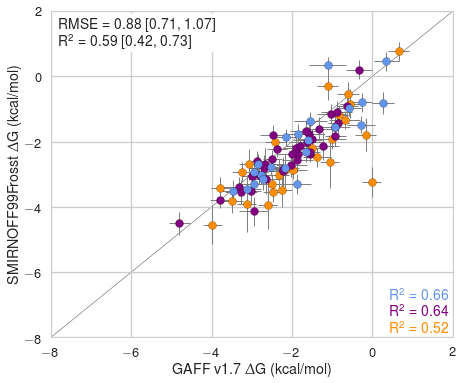

In [850]:
# SMIRNOFF99Frosst vs. GAFF v1.7

df = smirnoff.merge(bgbg, on=["System", "Type"], suffixes=("_smirnoff",
                                                                "_bgbg_tip3p"))
assert(len(df) == 86)

artist = scatter(df, 
        x="Delta G_bgbg_tip3p",
        y="Delta G_smirnoff",
        xerr="G_SEM_bgbg_tip3p",
        yerr="G_SEM_smirnoff",
        xlabel=r"GAFF v1.7 $\Delta$G (kcal/mol)",
        ylabel=r"SMIRNOFF99Frosst $\Delta$G (kcal/mol)",
        colors=colors,
        name="SMIRNOFF99Frosst-vs-GAFF-v1.7-dG-by-orientation",
        statistics_file_prefix="bgbg_smirnoff_by_orientation_dG_statistics")

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (56) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (54) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (52) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/mat

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (57) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (57) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (114) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/ma

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (107) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (99) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (97) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/ma

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (44) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (93) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))


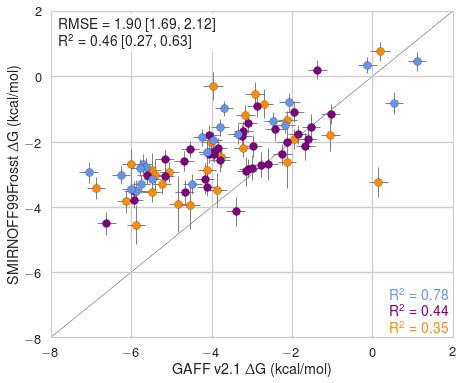

In [851]:
# SMIRNOFF99Frosst vs. GAFF v2.1

df = smirnoff.merge(bg2bg2, on=["System", "Type"], suffixes=("_smirnoff",
                                                                "_bg2bg2_tip3p"))
assert(len(df) == 86)

scatter(df, 
        x="Delta G_bg2bg2_tip3p",
        y="Delta G_smirnoff",
        xerr="G_SEM_bg2bg2_tip3p",
        yerr="G_SEM_smirnoff",
        xlabel=r"GAFF v2.1 $\Delta$G (kcal/mol)",
        ylabel=r"SMIRNOFF99Frosst $\Delta$G (kcal/mol)",
        colors=colors,
        name="SMIRNOFF99Frosst-vs-GAFF-v2.1-dG-by-orientation",
        statistics_file_prefix="bg2bg2_smirnoff_by_orientation_dG_statistics")

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (56) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (54) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (52) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/mat

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (77) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (83) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (69) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/mat

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (47) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (109) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (111) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/m

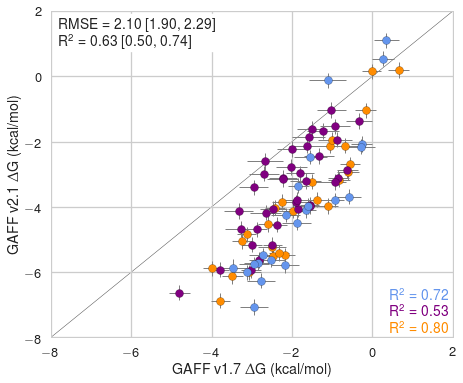

In [856]:
# GAFF v1.7 vs. GAFF v2.1

df = bgbg.merge(bg2bg2, on=["System", "Type"], suffixes=("_bgbg_tip3p",
                                                            "_bg2bg2_tip3p"))
assert(len(df) == 86)

scatter(df, 
        x="Delta G_bgbg_tip3p",
        y="Delta G_bg2bg2_tip3p",
        xerr="G_SEM_bgbg_tip3p",
        yerr="G_SEM_bg2bg2_tip3p",
        xlabel=r"GAFF v1.7 $\Delta$G (kcal/mol)",
        ylabel=r"GAFF v2.1 $\Delta$G (kcal/mol)",
        colors=colors,
        name="GAFF-v2.1-vs-GAFF-v1.7-dG-by-orientation",
        statistics_file_prefix="bgbg_bg2bg2_by_orientation_dG_statistics")

## Combined results with pre-computed statistics

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (56) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (54) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (52) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/mat

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (83) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (77) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (73) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/mat

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (50) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (48) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (69) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/mat

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (82) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (78) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (79) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/mat

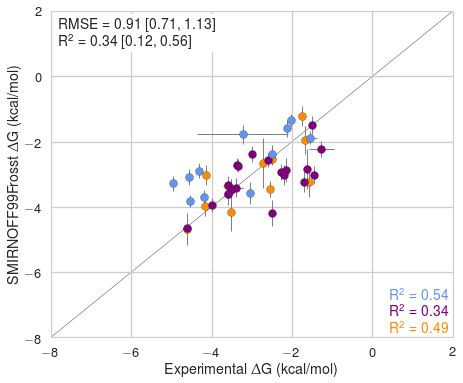

In [857]:
# SMIRNOFF99Frosst vs. Experiment

df = smirnoff_combined.merge(experimental, on=["System"], suffixes=("_smirnoff",
                                                                "_experiment"))
assert(len(df) == 43)

scatter(df, 
        x="Delta G_experiment",
        y="Delta G_smirnoff",
        xerr="G_SEM_experiment",
        yerr="G_SEM_smirnoff",
        xlabel=r"Experimental $\Delta$G (kcal/mol)",
        ylabel=r"SMIRNOFF99Frosst $\Delta$G (kcal/mol)",
        colors=colors,
        name="SMIRNOFF99Frosst-vs-Experiment-dG",
        statistics_file_prefix="experimental_smirnoff_dG_statistics")

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (56) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (54) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (52) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/mat

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (65) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (70) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (70) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/mat

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (109) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (101) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (110) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (53) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (77) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (83) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/mat

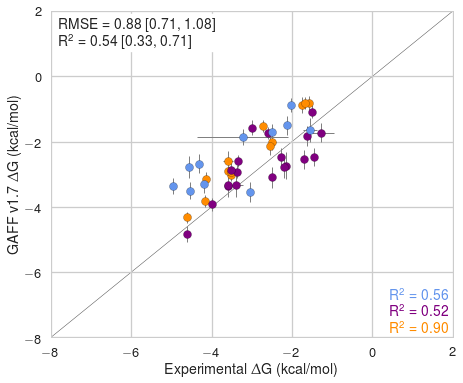

In [858]:
# GAFF v1.7 vs. Experiment

df = bgbg_combined.merge(experimental, on=["System"], suffixes=("_bgbg",
                                                                "_experiment"))
assert(len(df) == 43)

scatter(df, 
        x="Delta G_experiment",
        y="Delta G_bgbg",
        xerr="G_SEM_experiment",
        yerr="G_SEM_bgbg",
        xlabel=r"Experimental $\Delta$G (kcal/mol)",
        ylabel=r"GAFF v1.7 $\Delta$G (kcal/mol)",
        colors=colors,
        name="GAFF-v1.7-vs-Experiment-dG",
        statistics_file_prefix="experimental_bgbg_dG_statistics")

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (56) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (54) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (52) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/mat

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (65) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (70) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (70) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/mat

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (105) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (109) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (101) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (55) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (77) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (83) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/mat

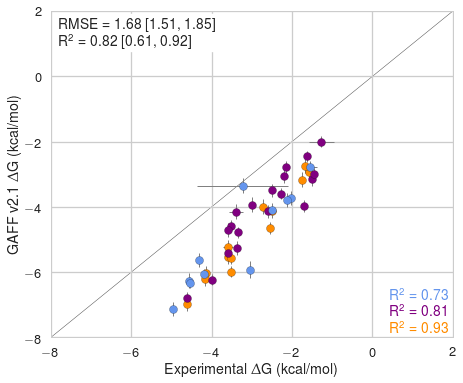

In [859]:
# GAFF v2.1 vs. Experiment

df = bg2bg2_combined.merge(experimental, on=["System"], suffixes=("_bg2bg2",
                                                                "_experiment"))
assert(len(df) == 43)

scatter(df, 
        x="Delta G_experiment",
        y="Delta G_bg2bg2",
        xerr="G_SEM_experiment",
        yerr="G_SEM_bg2bg2",
        xlabel=r"Experimental $\Delta$G (kcal/mol)",
        ylabel=r"GAFF v2.1 $\Delta$G (kcal/mol)",
        colors=colors,
        name="GAFF-v2.1-vs-Experiment-dG",
        statistics_file_prefix="experimental_bg2bg2_dG_statistics")

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (56) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (54) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (52) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/mat

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (77) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (83) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (69) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/mat

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (47) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (109) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (111) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/m

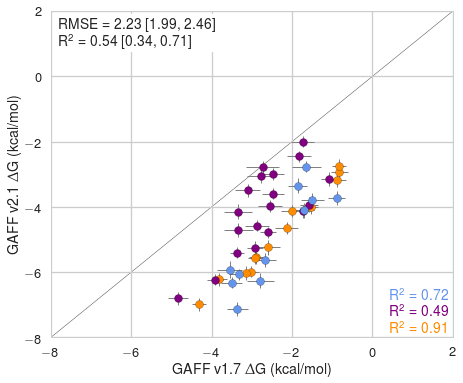

In [860]:
# GAFF v1.7 vs. GAFF v2.1

df = bg2bg2_combined.merge(bgbg_combined, on=["System", "Type"], suffixes=("_bg2bg2",
                                                                "_bgbg"))
assert(len(df) == 43)

scatter(df, 
        x="Delta G_bgbg",
        y="Delta G_bg2bg2",
        xerr="G_SEM_bgbg",
        yerr="G_SEM_bg2bg2",
        xlabel=r"GAFF v1.7 $\Delta$G (kcal/mol)",
        ylabel=r"GAFF v2.1 $\Delta$G (kcal/mol)",
        colors=colors,
        name="GAFF-v2.1-vs-GAFF-v1.7-dG",
        statistics_file_prefix="bgbg_bg2bg2_dG_statistics")

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (56) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (54) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (52) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/mat

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (82) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (78) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (79) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/mat

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (46) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (55) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (71) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/mat

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (69) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (91) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (44) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/mat

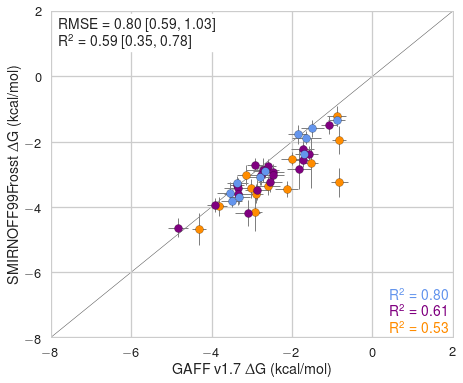

In [861]:
# SMIRNOFF99Frosst vs. GAFF v1.7

df = smirnoff_combined.merge(bgbg_combined, on=["System", "Type"], suffixes=("_smirnoff",
                                                                "_bgbg"))
assert(len(df) == 43)

scatter(df, 
        x="Delta G_bgbg",
        y="Delta G_smirnoff",
        xerr="G_SEM_bgbg",
        yerr="G_SEM_smirnoff",
        xlabel=r"GAFF v1.7 $\Delta$G (kcal/mol)",
        ylabel=r"SMIRNOFF99Frosst $\Delta$G (kcal/mol)",
        colors=colors,
        name="SMIRNOFF99Frosst-vs-GAFF-v1.7-dG",
        statistics_file_prefix="bgbg_smirnoff_dG_statistics")

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (56) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (54) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (52) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/mat

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (78) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (79) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (57) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/mat

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (71) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (40) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (107) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/ma

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (69) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (91) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (44) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/mat

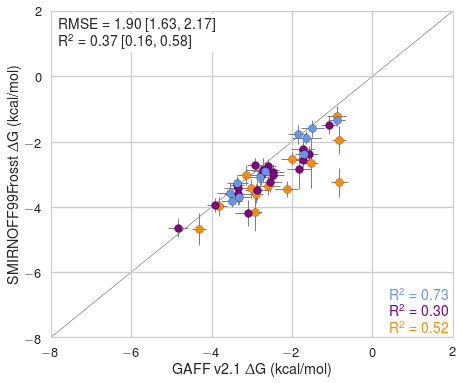

In [862]:
# SMIRNOFF99Frosst vs. GAFF v2.1

df = smirnoff_combined.merge(bgbg_combined, on=["System", "Type"], suffixes=("_smirnoff",
                                                                "_bg2bg2"))
assert(len(df) == 43)

scatter(df, 
        x="Delta G_bg2bg2",
        y="Delta G_smirnoff",
        xerr="G_SEM_bg2bg2",
        yerr="G_SEM_smirnoff",
        xlabel=r"GAFF v2.1 $\Delta$G (kcal/mol)",
        ylabel=r"SMIRNOFF99Frosst $\Delta$G (kcal/mol)",
        colors=colors,
        name="SMIRNOFF99Frosst-vs-GAFF-v2.1-dG",
        statistics_file_prefix="bg2bg2_smirnoff_dG_statistics")

# Compare binding to alpha and beta

In [775]:
def scatter_by_cyclodextrin(df, x, y, xerr, yerr, xlabel, ylabel):
    fig, ax = plt.subplots(1, figsize=(6 * 1.2 * 1/0.85, 6))
    
    lines_to_draw = sum([len(df[df["Guest"] == i]) == 2 for i in df["Guest"].unique()])
    colors = sns.color_palette("husl", lines_to_draw)
    color_index = 0
    
    for index, guest in enumerate(sorted(df["Guest"].unique())):
        tmp = df[df["Guest"] == guest]
            
        if len(tmp) == 2:
            
            ax.errorbar(
                tmp[x],
                tmp[y],
                fmt="o",
                markersize=12,
                markeredgecolor="k",
                markeredgewidth=0.2,
                elinewidth=1.0,
                ecolor="0.5",
                color=colors[color_index],
                label=guest,
            )
            
            line = ax.plot(
                tmp[x],
                tmp[y],
                color = colors[color_index],
                label="",
            )
            add_arrow(line[0])
            color_index += 1
        else:
            pass
        
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.85, box.height])
    ax.legend(loc='center right', bbox_to_anchor=(1.25, 0.5), ncol=1)

    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.plot([-50, 50], [-50, 50], ls="-", c="0.3", zorder=-1, lw="0.5")
    ax.set_ylim(-8, 2)
    ax.set_xlim(-8, 2)



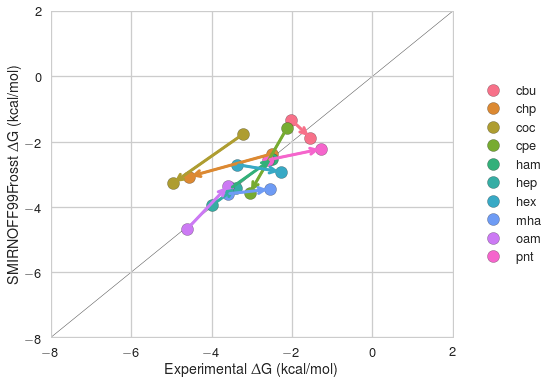

In [776]:
df = smirnoff_combined.merge(experimental, on=["System"], suffixes=("_smirnoff",
                                                                "_experiment"))
df["Cyclodextrin"] = df["System"].str.split("-").str[0] 
df["Guest"] = df["System"].str.split("-").str[1]

scatter_by_cyclodextrin(df, 
        x="Delta G_experiment",
        y="Delta G_smirnoff",
        xerr="G_SEM_experiment",
        yerr="G_SEM_smirnoff",
        xlabel=r"Experimental $\Delta$G (kcal/mol)",
        ylabel=r"SMIRNOFF99Frosst $\Delta$G (kcal/mol)",
        )

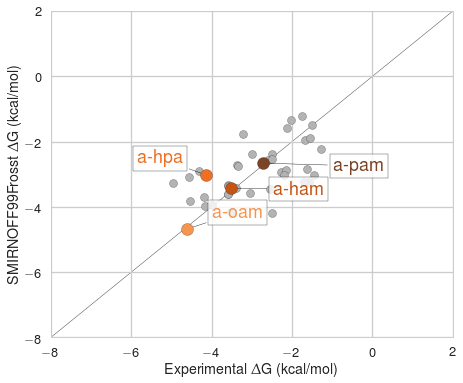

In [771]:
scatter_with_highlight(df,         
        x="Delta G_experiment",
        y="Delta G_smirnoff",
        xerr="G_SEM_experiment",
        yerr="G_SEM_smirnoff",
        xlabel=r"Experimental $\Delta$G (kcal/mol)",
        ylabel=r"SMIRNOFF99Frosst $\Delta$G (kcal/mol)",
        highlight=["a-pam", "a-ham", "a-hpa", "a-oam"],
        palette="Oranges_d"
)

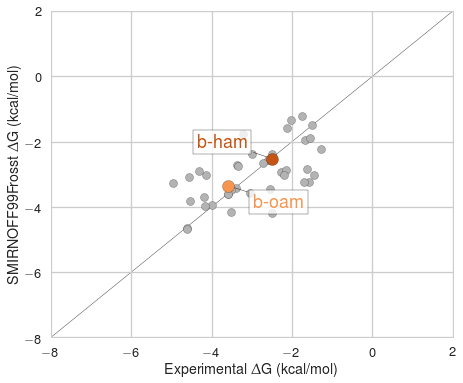

In [772]:
scatter_with_highlight(df,         
        x="Delta G_experiment",
        y="Delta G_smirnoff",
        xerr="G_SEM_experiment",
        yerr="G_SEM_smirnoff",
        xlabel=r"Experimental $\Delta$G (kcal/mol)",
        ylabel=r"SMIRNOFF99Frosst $\Delta$G (kcal/mol)",
        highlight=["b-pam", "b-ham", "b-hpa", "b-oam"],
        palette="Oranges_d"
)

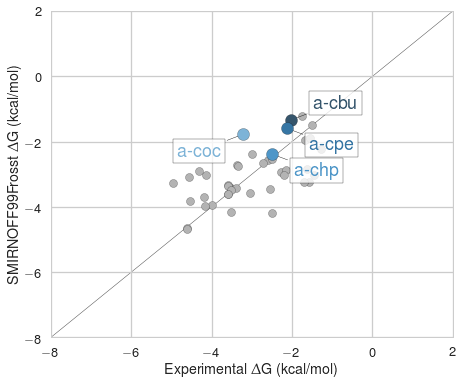

In [773]:
scatter_with_highlight(df,         
        x="Delta G_experiment",
        y="Delta G_smirnoff",
        xerr="G_SEM_experiment",
        yerr="G_SEM_smirnoff",
        xlabel=r"Experimental $\Delta$G (kcal/mol)",
        ylabel=r"SMIRNOFF99Frosst $\Delta$G (kcal/mol)",
        highlight=["a-cbu", "a-cpe", "a-chp", "a-coc"],
        palette="Blues_d"
)

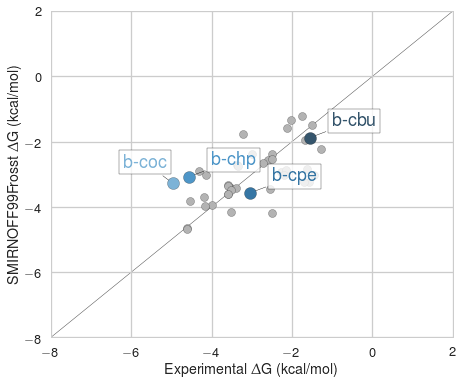

In [774]:
scatter_with_highlight(df,         
        x="Delta G_experiment",
        y="Delta G_smirnoff",
        xerr="G_SEM_experiment",
        yerr="G_SEM_smirnoff",
        xlabel=r"Experimental $\Delta$G (kcal/mol)",
        ylabel=r"SMIRNOFF99Frosst $\Delta$G (kcal/mol)",
        highlight=["b-cbu", "b-cpe", "b-chp", "b-coc"],
        palette="Blues_d"
)

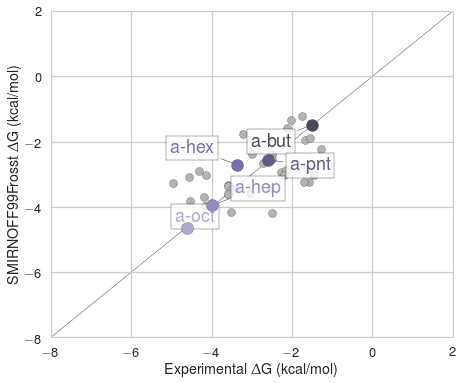

In [778]:
scatter_with_highlight(df,         
        x="Delta G_experiment",
        y="Delta G_smirnoff",
        xerr="G_SEM_experiment",
        yerr="G_SEM_smirnoff",
        xlabel=r"Experimental $\Delta$G (kcal/mol)",
        ylabel=r"SMIRNOFF99Frosst $\Delta$G (kcal/mol)",
        highlight=["a-but", "a-pnt", "a-hex", "a-hep", "a-oct"],
        palette="Purples_d"
)

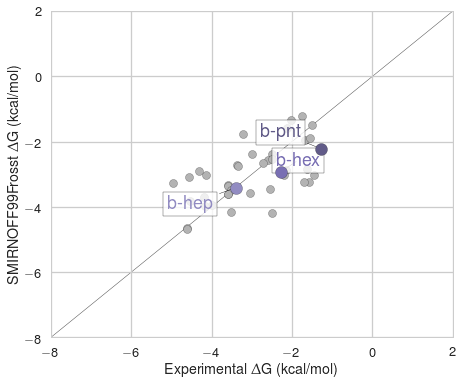

In [779]:
scatter_with_highlight(df,         
        x="Delta G_experiment",
        y="Delta G_smirnoff",
        xerr="G_SEM_experiment",
        yerr="G_SEM_smirnoff",
        xlabel=r"Experimental $\Delta$G (kcal/mol)",
        ylabel=r"SMIRNOFF99Frosst $\Delta$G (kcal/mol)",
        highlight=["b-but", "b-pnt", "b-hex", "b-hep", "b-oct"],
        palette="Purples_d"
)

# Plot the same guest in either orientation

In [644]:
df = smirnoff.merge(bgbg, on=["System", "Type"], suffixes=("_smirnoff",
                                                            "_bgbg_tip3p"))
df["Short"] = df["System"].str.split("-").str[0] + "-" + df["System"].str.split("-").str[1]

assert(len(df) == 86)

In [731]:
def scatter_by_orientation(df, x, y, xerr, yerr, xlabel, ylabel):
    
    fig, ax = plt.subplots(1, figsize=(6 * 1.2 * 1/0.85, 6))

    colors = sns.color_palette("husl", 3)
    color_index = 0

    colors = sns.color_palette("husl", len(df["Short"].unique()))
    for index, sys in enumerate(df["Short"].unique()):
        tmp = df[df["Short"] == sys]

        x_difference = abs(tmp[x].iloc[1] - tmp[x].iloc[0])
        y_difference = abs(tmp[y].iloc[1] - tmp[y].iloc[0])

        if x_difference > 2 or y_difference > 2:

            ax.errorbar(
                tmp[x],
                tmp[y],
                fmt="o",
                markersize=12,
                markeredgecolor="k",
                markeredgewidth=0.2,
                elinewidth=1.0,
                ecolor="0.5",
                color = colors[index],
                label=sys
            )

            line = ax.plot(
                tmp[x],
                tmp[y],
                color = colors[index],
                label="",
            )
                        
            add_arrow(line[0])
        else:
            ax.errorbar(
                tmp[x],
                tmp[y],
                fmt="o",
                markersize=8,
                markeredgecolor="k",
                markeredgewidth=0.2,
                elinewidth=1.0,
                ecolor="0.5",
                color = "0.7",
                label="",
                zorder=1,
            )


    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.85, box.height])
    ax.legend(loc='center right', bbox_to_anchor=(1.25, 0.5), ncol=1)

    ax.plot([-50, 50], [-50, 50], ls="-", c="0.3", zorder=-1, lw="0.5")
    ax.set_ylim(-8, 2)
    ax.set_xlim(-8, 2)

    


In [656]:
def add_arrow(line, position=None, direction='right', size=15, color=None):
    """
    add an arrow to a line.

    line:       Line2D object
    position:   x-position of the arrow. If None, mean of xdata is taken
    direction:  'left' or 'right'
    size:       size of the arrow in fontsize points
    color:      if None, line color is taken.
    """
    if color is None:
        color = line.get_color()

    xdata = line.get_xdata()
    ydata = line.get_ydata()

    if position is None:
        position = xdata.mean()
        
    line.axes.annotate('',
        xytext=(xdata[0], ydata[0]),
        xy=(xdata[1], ydata[1]),
        arrowprops=dict(arrowstyle="->", lw=3, color=color),
        size=size
    )


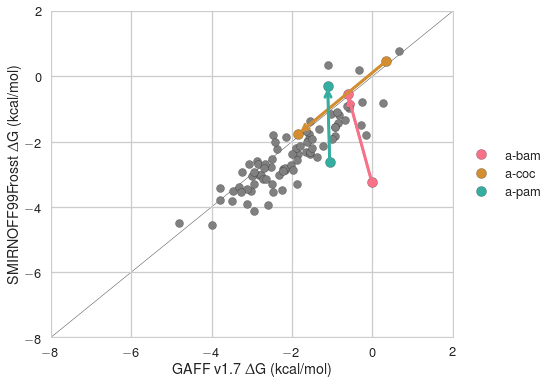

In [657]:
scatter_by_orientation(df,         
        x="Delta G_bgbg_tip3p",
        y="Delta G_smirnoff",
        xerr="G_SEM_bgbg_tip3p",
        yerr="G_SEM_smirnoff",
        xlabel=r"GAFF v1.7 $\Delta$G (kcal/mol)",
        ylabel=r"SMIRNOFF99Frosst $\Delta$G (kcal/mol)",
)

In [770]:
def scatter_with_highlight(df, x, y, xerr, yerr, xlabel, ylabel, highlight, palette="husl"):
    
    fig, ax = plt.subplots(1, figsize=(6 * 1.2, 6))

    colors = sns.color_palette(palette, len(highlight))
    color_index = 0
    texts = []
    my_patches = []
    
    for sys in highlight:
        tmp = df[df["System"] == sys]
        ax.errorbar(
        tmp[x],
        tmp[y],
        fmt="o",
        markersize=12,
        markeredgecolor="k",
        markeredgewidth=0.2,
        elinewidth=1.0,
        ecolor="0.5",
        color = colors[color_index],
        zorder=20
        )
        for i, j in zip(tmp[x].values, tmp[y].values):
            texts.append(ax.text(i, j, sys, size=18,
                              color = colors[color_index], 
                              bbox=dict(facecolor="w", alpha=0.8)))
            my_patches.append(patches.Circle((i, j), 
                       radius=0.11,
                       facecolor=None,
                       edgecolor=None,
                       alpha=0))

            
        color_index += 1
    
    for index, sys in enumerate(df["System"].unique()):
        tmp = df[df["System"] == sys]
        ax.errorbar(
            tmp[x],
            tmp[y],
            fmt="o",
            markersize=8,
            markeredgecolor="k",
            markeredgewidth=0.2,
            elinewidth=1.0,
            ecolor="0.5",
            color = "0.7",
            label="",
            zorder=1,
        )
            


    for p in my_patches:
            ax.add_patch(p)
    

    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)

    ax.plot([-50, 50], [-50, 50], ls="-", c="0.3", zorder=-1, lw="0.5")
    ax.set_ylim(-8, 2)
    ax.set_xlim(-8, 2)
    adjust_text(texts,
               ax=ax,
               add_objects=my_patches,
               expand_points=(2, 2),
               expand_text=(1.2, 1.4),
               arrowprops=dict(arrowstyle='-', color="black")
               )    


KeyError: 'Delta G_bgbg_tip3p'

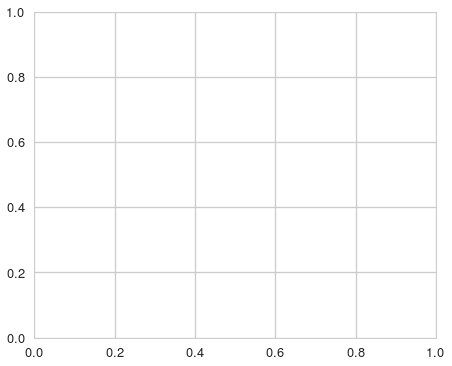

In [701]:
scatter_with_highlight(df,         
        x="Delta G_bgbg_tip3p",
        y="Delta G_smirnoff",
        xerr="G_SEM_bgbg_tip3p",
        yerr="G_SEM_smirnoff",
        xlabel=r"GAFF v1.7 $\Delta$G (kcal/mol)",
        ylabel=r"SMIRNOFF99Frosst $\Delta$G (kcal/mol)",
        highlight=["a-pam-p", "a-ham-p", "a-hpa-p", "a-oam-p"],
        palette="Oranges_d"
)